In [1]:
import pandas as pd
import folium as fo
import numpy as np
import matplotlib.pyplot as plt
import json
pd.set_option('mode.chained_assignment', None)

## Violation frequency by category  
Regrouping violations in common categories will need less plots while maintening readability and finer analysis.  
To do so, we created 5 categories (food safety, hygiene, equipment, recidivism and others).  
For the analysis, we first map violation's id to their new category and then proceed as usual.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
violation_category_mapping = pd.read_csv('resources/violation-id-meaning.csv').rename(columns={'Violation ID': 'id', 'Category': 'category'})
violation_category_mapping.index = violation_category_mapping.id
violation_category_mapping = violation_category_mapping.category

violation_categories = violation_category_mapping.unique()
violation_category_mapping.head()

id
1    Food safety
2    Food safety
3    Food safety
4    Food safety
5        Hygiene
Name: category, dtype: object

We also restrict the analysis to certain types of facility: ie restaurants and grocery stores.  

In [3]:
inspections = pd.read_parquet('resources/food-inspections-cleaned.parquet').rename(columns={'Inspection Date': 'date'})

In [4]:
categorized_violations = pd.read_parquet('resources/violations_oriented.parquet').rename(columns={'Violation ID': 'id', 'Inspection Date': 'date'})
categorized_violations.index = categorized_violations.date
categorized_violations['category'] = categorized_violations.id.map(lambda x: violation_category_mapping.get(x))

In [5]:
def daily_category_rate_by_facility(facility_type):
    filtered_violations = categorized_violations[categorized_violations['Facility Type'] == facility_type]
    categorized_violations_per_day = filtered_violations[['category']]
    categorized_violations_per_day['v_count'] = 1
    categorized_violations_per_day = categorized_violations_per_day.groupby(by=['date', 'category']).sum()
    
    inspections_per_day = inspections[inspections['Facility Type'] == facility_type]
    inspections_per_day['i_count'] = 1
    inspections_per_day = inspections_per_day[['date', 'i_count']]
    inspections_per_day = inspections_per_day.groupby(by='date').sum()
    
    normalized_violation_rate = categorized_violations_per_day.join(inspections_per_day)
    normalized_violation_rate['rate'] = normalized_violation_rate.v_count / normalized_violation_rate.i_count
    normalized_violation_rate = normalized_violation_rate[['rate']].reset_index()
    return normalized_violation_rate

In [7]:
daily_category_rate_by_facility('Restaurant')

/home/ingeborg/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ingeborg/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,category,rate
0,2010-01-04,Equipment,1.000000
1,2010-01-04,Hygiene,1.285714
2,2010-01-05,Equipment,1.484848
3,2010-01-05,Food safety,0.030303
4,2010-01-05,Hygiene,2.484848
...,...,...,...
11521,2019-10-24,Hygiene,0.500000
11522,2019-10-24,Other,0.050000
11523,2019-10-24,Recidivism,0.050000
11524,2019-10-25,Food safety,1.000000


Now that we have the violations count, we also need to normalize this figure by the number of inspection to have less biased data.  
We can count inspections from the original dataset.

/home/ingeborg/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ingeborg/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


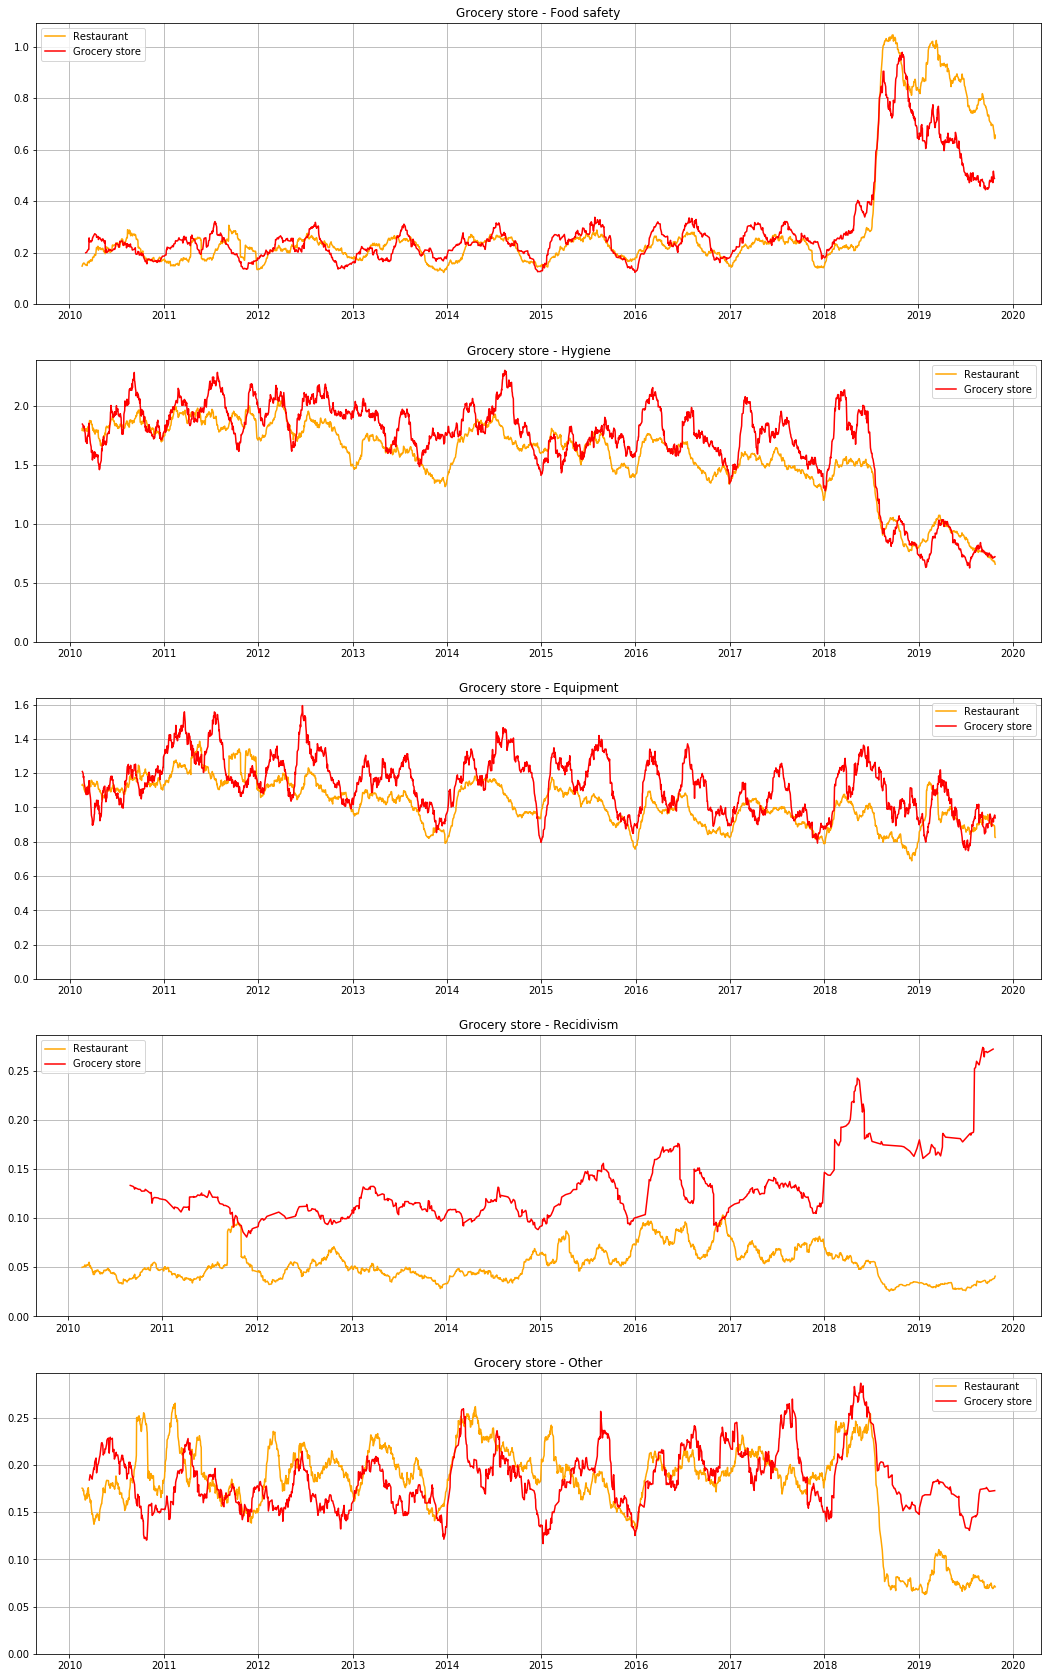

In [30]:
facility_types = ['Restaurant', 'Grocery store']
colors = ['orange', 'red']
fig, axs = plt.subplots(len(violation_categories), 1, figsize=(18,30))

for j, f_type in enumerate(facility_types):
    facility_rate = daily_category_rate_by_facility(f_type)
    for i, v_cat in enumerate(violation_categories):
        filtered = facility_rate[facility_rate.category == v_cat]
        rolling_mean = filtered.rate.rolling(window=30).mean()
        axs[i].set_title('{} - {}'.format(f_type, v_cat))
        axs[i].plot(filtered['date'].values, rolling_mean, colors[j])
        

for i, v_cat in enumerate(violation_categories):
    axs[i].legend(facility_types)
    axs[i].grid()
    axs[i].set_ylim(bottom=0)

We can observe high periodicity with food safety, hygiene and equipment related violations.  
They all have the same peak around summer (when restauration is at its peak)
